In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pulse2percept as p2p

2017-03-29 12:30:21,064 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
# Load an Argus II array and place it on the fovea
argus = p2p.implants.ArgusII()

In [3]:
# Start the simulation framework
sim = p2p.Simulation(argus, engine='joblib', num_jobs=6)

In [4]:
# Set parameters of the optic fiber layer (OFL)
sim.set_optic_fiber_layer(sampling=25)

2017-03-29 12:30:21,236 [pulse2percept.retina] [INFO] File './retina_s25_l2.0_rot0.0_6000x4000.npz' doesn't exist or has outdated parameter values, generating...


In [5]:
# Set parameters of the ganglion cell layer (GCL)
t_gcl = 0.01 / 1000
sim.set_ganglion_cell_layer(tsample=t_gcl)

In [6]:
# Send a pulse train to two specific electrodes, set all others to zero
pt = p2p.stimuli.PulseTrain(t_gcl, freq=20, amp=20, dur=0.1)

In [14]:
if meow:
    print('hello')

NameError: name 'meow' is not defined

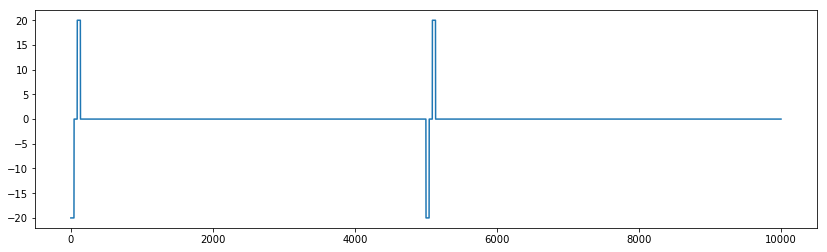

In [7]:

plt.figure(figsize=(14, 4))
plt.plot(pt.data)

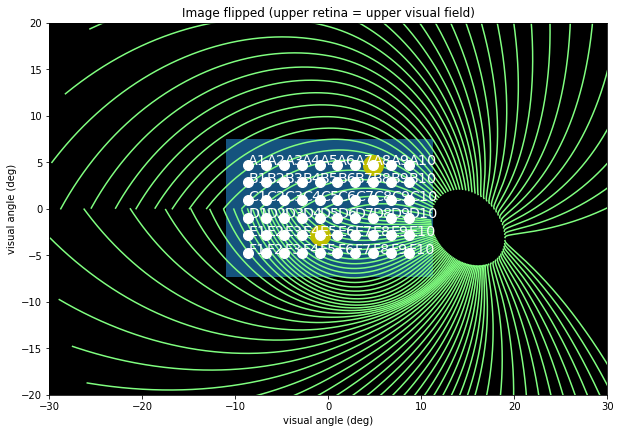

In [11]:
stim = {'E5': pt, 'A8': pt}
sim.plot_fundus(stim)
plt.axis([-30, 30, -20, 20])
plt.savefig('fundus.eps')

In [9]:
percept = sim.pulse2percept(stim, tol=0.25, layers=['GCL', 'OFL'])

2017-03-29 12:35:51,539 [pulse2percept.api] [INFO] Starting pulse2percept...
2017-03-29 12:37:00,709 [pulse2percept.api] [INFO] tol=25.0%, 36367/38801 px selected
2017-03-29 12:39:45,696 [pulse2percept.api] [INFO] Done.


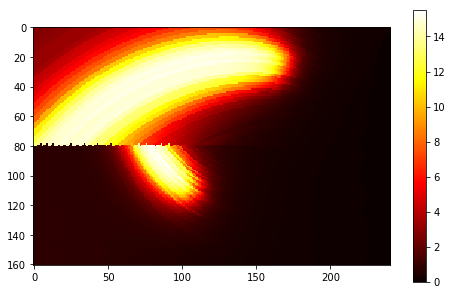

In [12]:
frame = p2p.get_brightest_frame(percept)
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='hot')
plt.colorbar()
plt.savefig('percept.eps')

In [ ]:
sim.ofl.